# Understanding Real Estate Prices

My motivation for creating this project is to primarily identify key features which influence house prices. I am currently the in the search for houses in the Bay Area for investing. If you have any leads, feel free to contact me at `kendric "dot" v "dot" ng [at] vanderbilt "dot" edu`.

I extracted residential house data from a popular real estate website during February 2020 using a third party Chrome extension web scraper. As with HTML/CSS based web scrapers, data may not be located at the same HTML/CSS tags and can either get misplaced or list!

This `Exploration` notebook aims to understand the data surrounding real estate.

This is part two of my three part series on real estate prices. Please go to one of the other notebooks below if you're interested:

1. `Preprocessing`: data cleaning
2. `Exploration`: business and data understanding
3. `Prediction`: model building and prediction

Let's import the necessary python packages for this analysis.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

file = './data/clean.csv'
data = pd.read_csv(file)
data.head()

,price,bed,bath,sqft,type,yearbuilt,heating,cooling,area,parking_spaces,parking1,parking2,parking3
0,795000.0,NaN,NaN,10890.0,NaN,NaN,NaN,NaN,South Bay,NaN,NaN,NaN,NaN
1,4399999.0,5.0,4.0,3399.0,Single Family,2020.0,Other,Central,South Bay,NaN,Attached Garage,NaN,NaN
2,1450000.0,NaN,NaN,24829.2,NaN,NaN,NaN,NaN,South Bay,NaN,NaN,NaN,NaN
3,90000.0,NaN,NaN,4926.0,NaN,NaN,NaN,NaN,South Bay,NaN,NaN,NaN,NaN
4,225000.0,NaN,NaN,5401.0,NaN,NaN,NaN,NaN,South Bay,NaN,NaN,NaN,NaN


I would like to break down this analysis using the the CRISP-DM Process (Cross Industry Process for Data Mining):

1. Business Understanding;
2. Data Understanding;
3. Prepare Data;
4. Data Modeling;
5. Evaluate Results; and
6. Deploy.

In this notebook, I will be focusing on the first two: 

1. Business Understanding; and
2. Data Understanding.

The rest of the CRISP-DM process will be performed at a separate notebook.

# 1. Business Understanding

For this project, I want to understand the following:

1. What are the key factors associated with housing prices in the Bay Area?
2. Are there special relationships between specific factors?
3. What else can I understand about the Bay Area real estate market?


# 2. Data Understanding

I've parsed much of the data in the `Preprocessing` notebook, so please refer to that notebook for any details that I may have left out here.

In [2]:
def print_missing_data(data):
    all_data_na = (data.isnull().sum() / len(data)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
    print(missing_data)

In [3]:
print_missing_data(data)

                Missing Ratio
parking3            99.932065
parking2            99.082880
cooling             68.104620
parking1            66.813859
parking_spaces      59.103261
heating             46.025815
bath                44.327446
sqft                38.654891
bed                 11.582880
yearbuilt            8.186141
type                 5.808424


## Types of Houses in the Bay

Let's firstly look at where houses are located (`Area`) and what type of houses there are (`type`).

In [4]:
def count_category(df, column, title="Proportional Count", plot=False):
    '''
    Create a dataframe containing the proportion of each categorical feature
    INPUT 
        df - the dataframe
        column - column name
        title - string the title of your plot
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        props_count_df - a dataframe with the counts of a column in percentages
        Displays a plot related to the column count
    '''
    count_df = df[column].value_counts().reset_index()
    count_df.rename(columns={'index': column, column: 'count'}, inplace=True)
    count_df.set_index(column, inplace=True)
    props_count_df = count_df / count_df.sum()
    
    # plot if requested
    if plot:
        props_count_df.plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()

    return props_count_df

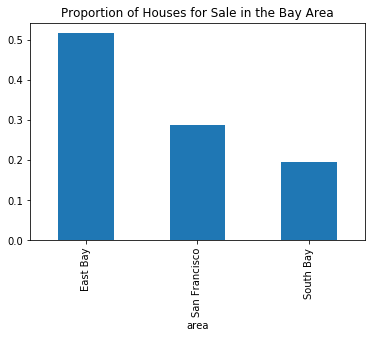

In [5]:
house_by_area = count_category(data, 'area', title='Proportion of Houses for Sale in the Bay Area', plot=True)

It seems that about half of houses being sold on this website are from `East Bay`. There must be lots of seller activity in the area. Meanwhile, `South Bay` has the least proportion of houses being sold in the Bay. 

I wonder if this is because there isn't as much development in the area or there are not many people who want to sell their houses. If neither of these, then sellers in `East Bay` are likely most active.

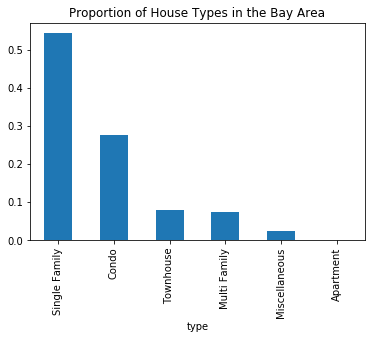

In [6]:
house_by_type = count_category(data, 'type', title='Proportion of House Types in the Bay Area', plot=True)

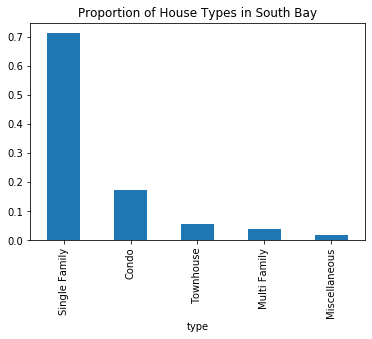

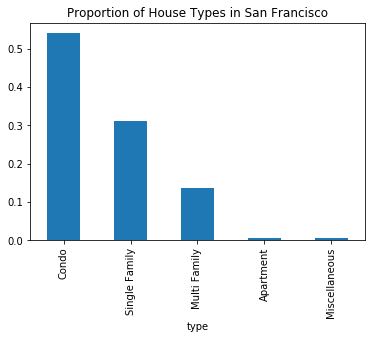

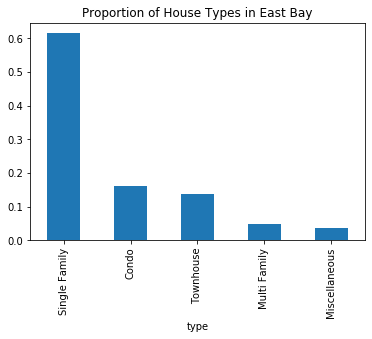

In [7]:
for area in data['area'].unique():
    count_category(data[data['area'] == area], 'type', title='Proportion of House Types in {}'.format(area), plot=True)

In general, most of the house listings here are `Single Family`, which makes sense since these are the most popular type of houses being sold. 

It's curious to see however that for `San Francisco`, `Condos` are the majoring of houses that are being sold! This makes sense if we're talking about downtown `San Francisco` where `Single Family` houses may not be as common.

## Housing Prices

Now the coveted story of the decade, how expensive are houses here at the Bay?

In [8]:
def draw_boxplot(data, col_x, col_y):
    """Draw a boxplot based on two columns"""
    test = data[[col_x, col_y]]
    ax = sns.boxplot(x=col_x, y=col_y, data=test);
    return ax

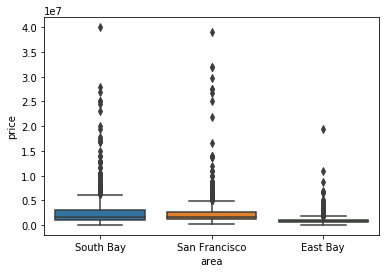

In [9]:
draw_boxplot(data, 'area', 'price');

While a majority of houses are at most `$4 million`, it seems that this dataset has huge outlying houses of at least `$10 million` houses. Let's look at `East Bay` to zoom in on the price action.

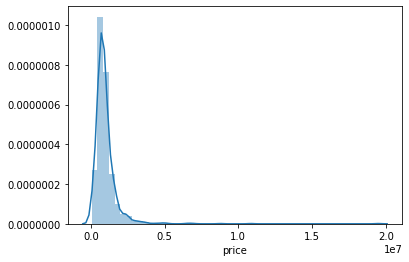

In [10]:
test = data.loc[data['area'] == 'East Bay', 'price']
sns.distplot(test);

Even in `East Bay`, which is considered to be on average a cheaper neighborhood compared to `South Bay` and `San Francisco`, many outlying houses are expensive! Let's remove the outliers from our viewing window and see how the houses across these three districts are distributed.

In [11]:
def draw_distplot(data, col_x, col_y, value=None, multiple_categories=True):
    """
    Draw a distribution plot for col_y based on col_x
    
    Inputs:
        data                - the dataframe
        col_x               - categorical column to slice by
        col_y               - target column
        multiple_categories - set to false if only mapping one value
        value               - set value for single category
    
    Output:
        a distribution plot
    
    """
    # for more than one category
    if multiple_categories:
        for col in data[col_x].unique():
            sns.distplot(data.loc[data[col_x] == col, col_y], label=col, hist=False, rug=True)
    else:
        sns.distplot(data.loc[data[col_x] == value, col_y], label=value, hist=False, rug=True)
    plt.legend()
    plt.show()

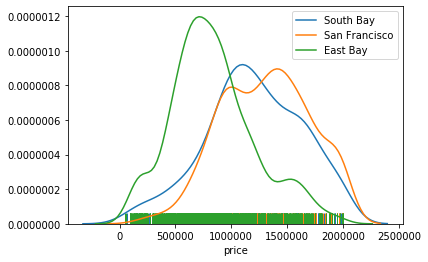

In [12]:
test = data[data['price'] < int(2e6)]
draw_distplot(test, 'area', 'price')

On average, it seems that the distribution of houses are cheapest in `East Bay`. Housing prices in `San Francisco` and `South Bay` seem to be around the same on average. Let's look at the price statistics for each area.

In [13]:
def summary_statistics(data, col_x, col_y):
    """Print summary statistics for two columns"""
    stats = data.groupby([col_x]).describe()[col_y][['count', 'mean', 'min', '50%', 'max']].sort_values(by='50%')
    print(stats)

In [14]:
summary_statistics(data, 'area', 'price')

                count          mean       min        50%         max
area                                                                
East Bay       1521.0  9.700553e+05   48250.0   817040.0  19500000.0
South Bay       575.0  2.993783e+06   69000.0  1595000.0  39988000.0
San Francisco   848.0  2.587687e+06  187620.0  1604000.0  39000000.0


As suspected, the average (mean) East Bay house is less than `$1 million` while other areas' houses are in the `$2.5-3.0 million` range. Also, seeing that the middle 50% (or median) of houses are far from the mean. That means that there are many outliers in the dataset that are skeweing the prices upward.

When I extracted the information from the real estate website, many of the houses are mansions and other luxurious houses, so this makes sense.

In [15]:
summary_statistics(data, 'type', 'price')

                count          mean        min        50%         max
type                                                                 
Miscellaneous    68.0  5.482468e+05    69000.0   244500.0   7950000.0
Townhouse       222.0  9.071618e+05   499000.0   856440.0   2295000.0
Condo           768.0  1.519642e+06   187620.0  1101495.0  25000000.0
Single Family  1504.0  2.118543e+06   226007.0  1170422.0  39988000.0
Multi Family    206.0  2.627195e+06   499000.0  1799500.0  27500000.0
Apartment         5.0  3.304000e+06  1475000.0  2995000.0   5595000.0


`Townhouse` and `Miscellaneous` housing types seem to be the cheapest, while `Condo`, `Single Family`, `Multi Family` and `Apartment` seem to be more expensive on average.

Loking at the range of houses, it seems that `Condo`, `Single Family` and `Multi Family` can get really expensive on the higher end of the scales. Again, this is due to the `mean` being significantly higher than the `median`, implicating outliers in the set. Here's another view of the outliers in the data.

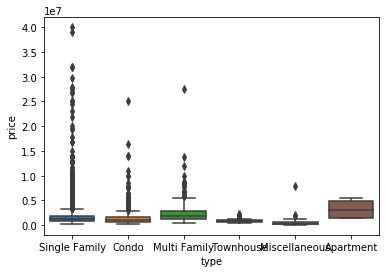

In [16]:
draw_boxplot(data, 'type', 'price');

Let's look at the houses on the lower end of the scale.

In [17]:
summary_statistics(data[data['price'] < 200000], 'type', 'price')

               count           mean       min       50%       max
type                                                             
Miscellaneous   21.0  150119.047619   69000.0  156000.0  199000.0
Condo            2.0  187620.000000  187620.0  187620.0  187620.0


It seems like most of them are `Miscellaneous` types. These can range from co-ops to mobile parks as defined by that database.

In [18]:
summary_statistics(data[data['price'] < 200000], 'area', 'price')

               count           mean       min       50%       max
area                                                             
South Bay        6.0  118833.333333   69000.0  115000.0  165000.0
East Bay        63.0  150309.523810   48250.0  155000.0  199950.0
San Francisco    2.0  187620.000000  187620.0  187620.0  187620.0


As we suspected, they're mostly from the `East Bay` Area.

Now let's look at houses on the higher range of the spectrum!

In [19]:
summary_statistics(data[data['price'] > 5000000], 'type', 'price')

               count          mean        min        50%         max
type                                                                
Apartment        1.0  5.595000e+06  5595000.0  5595000.0   5595000.0
Multi Family    23.0  8.400826e+06  5095000.0  6950000.0  27500000.0
Condo           19.0  9.371474e+06  5200000.0  7500000.0  25000000.0
Miscellaneous    1.0  7.950000e+06  7950000.0  7950000.0   7950000.0
Single Family  105.0  1.159284e+07  5100000.0  8500000.0  39988000.0


Most houses that are more than `$5 million` are `Single Family` houses. Let's look at them proportionally to see what the percentage breakdown looks like.

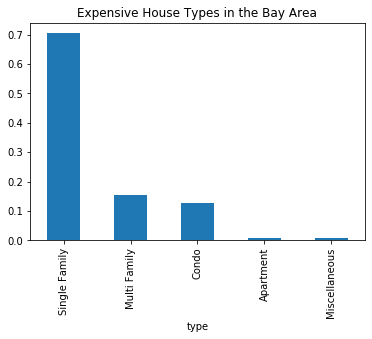

In [20]:
expensive_house_by_type = count_category(data[data['price'] > 5000000], 'type', \
                                         title='Expensive House Types in the Bay Area', \
                                         plot=True)

Hence, about 70% of the expensive houses in the dataset are `Single Family` houses. However, we already knew that `Single Family` houses will be overrepresented here. Let's compare the ratios for regular houses and expensive houses by type.

In [21]:
# rename columns
expensive_house_by_type.columns = ['percent_house_expensive']
house_by_type.columns           = ['percent_house']

# create a new dataframe to calculate the percent differential
house_diff = expensive_house_by_type.merge(house_by_type, left_index=True, right_index=True)
house_diff.loc[:, 'percent_diff'] = house_diff['percent_house_expensive'] - \
                                    house_diff['percent_house']
house_diff.sort_values('percent_diff', ascending=False)

,percent_house_expensive,percent_house,percent_diff
type,,,
Single Family,0.704698,0.542373,0.162325
Multi Family,0.154362,0.074288,0.080075
Apartment,0.006711,0.001803,0.004908
Miscellaneous,0.006711,0.024522,-0.017811
Condo,0.127517,0.276956,-0.149440


Looking at the share of houses which are more expensive, it seems that `Single Family`, `Multi Family` and `Apartment` types had the largest contribution to expensive housing.

We also know that there are variations in price by `area`. So let's further break down the `price` comparisons by `area` by `type`.

In [22]:
def price_stats_by_area_type(type_):
    """Prints out price statistics by area based on one house type"""
    price_by_area_type = data.groupby(['area', 'type']).describe()['price']
    stats = price_by_area_type.loc[[
        ('East Bay'     , type_), 
        ('San Francisco', type_),
        ('South Bay'    , type_)
    ], ['count', '25%', '50%', '75%']]
    print(stats)

In [23]:
price_stats_by_area_type('Single Family')

                             count        25%        50%         75%
area          type                                                  
East Bay      Single Family  860.0   669101.0   918043.0  1249999.25
San Francisco Single Family  259.0  1256667.5  1619313.0  2992500.00
South Bay     Single Family  385.0  1209575.0  1925000.0  3883750.00


The middle 50% of `Single Family` houses in `San Francisco` are almost twice as expensive as those in `East Bay` and more than twice as expensive as those in `South Bay`.

Let's now look at `Condo` houses.

In [24]:
price_stats_by_area_type('Condo')

                     count        25%        50%        75%
area          type                                         
East Bay      Condo  225.0   538888.0   706788.0   955000.0
San Francisco Condo  450.0  1004250.0  1470000.0  2112000.0
South Bay     Condo   93.0   699000.0   957320.0  1367923.0


`Condo`s in `San Francisco` are the most expensive by far. 

Now that we've looked at the most basic housing features i.e. `price`, `area` and `type`, let's now look at other features in the dataset that might be interesting.

## Square Footage: How Large are These Houses?

Since we saw a lot of expensive prices earlier in the section, we'll probably see some mansions and large estates as indicated by square footage as well! Let's check it out.

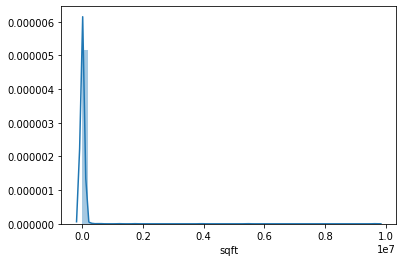

In [25]:
test = data['sqft']
sns.distplot(test);

This is clearly not a pretty sight to see. Let's find other ways to parse the `sqft` data. Let's look at it by `area` and reduce the scope of outliers.

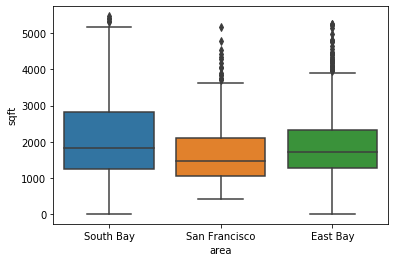

In [26]:
draw_boxplot(data[data['sqft'] < 5500], 'area', 'sqft');

Better with few outliers. 

What can we see here? It seems that houses in `San Francisco` has the tighest middle 50% quantile, meaning houses there seem to be more around the same size. This is likely due to there having more `Condo` style houses, and it is a dense area.

`South Bay` clearly has the largest range of `sqft` here. You can think of all the rich VCs and techies living in this area, hence there will likely be larger houses here.

As for `East Bay`, while the range is tighter than that of `South Bay`, even it has a lot of outliers in terms of big houses and lots!

Now let's look at `sqft` by `type!

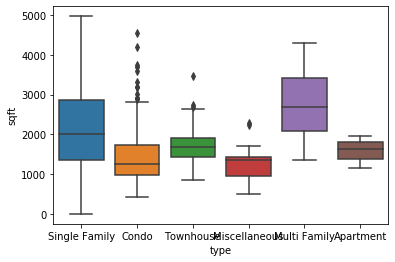

In [27]:
draw_boxplot(data[data['sqft'] < 5000], 'type', 'sqft');

Since `Single Family` has the largest proportion of houses in this set, I'm not surprised that they also have the largest range in terms of size.

As for `Multi Family`, we know that they tend to be larger than `Single Family` but have a smaller range because there are just fewer of them around.

Other house types seem to hover around the same middle range of `1,000` to `2,000 sqft`, and this makes sense as these houses are not meant to be built so large like the `Single Family` and `Multi Family` types.

## Bed, Bath and Beyond: How Many People Can These Houses Accommodate?

Now, let's look at `bed` and `bath`. Instead of just counting how many they are, let's look at their average propensities across `type` and `area`.

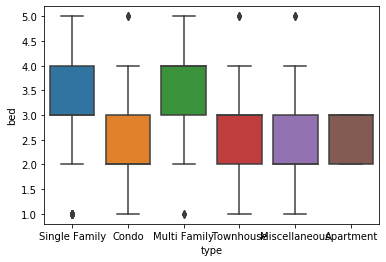

In [28]:
draw_boxplot(data[data['bed'] < 6], 'type', 'bed');

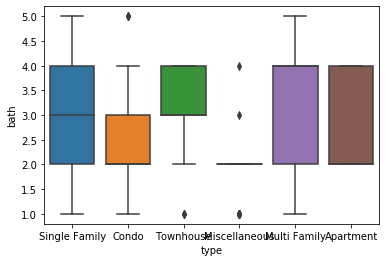

In [29]:
draw_boxplot(data[data['bath'] < 6], 'type', 'bath');

Well, that's comforting! At least the average house will have at least `2` to `4` beds and baths. Now we don't have to worry about our sleep and toilet breaks!

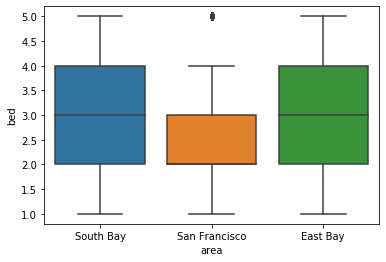

In [45]:
draw_boxplot(data[data['bed'] < 6], 'area', 'bed');

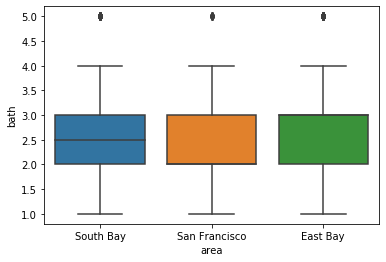

In [44]:
draw_boxplot(data[data['bath'] < 6], 'area', 'bath');

Do we have some `bed` discrimination here? Why does `San Francisco` have fewer beds on average than the other areas? It's likely because there are more `Condo` types than `Single Family` types, and as we saw earlier, `Condo`s have fewer beds than `Single Family`.

At least `baths` are more equitable!

## Year Built: How Old are These Houses?

We know that the Bay Area (and California) is relatively an old establishment. Let's look at how old these houses are.

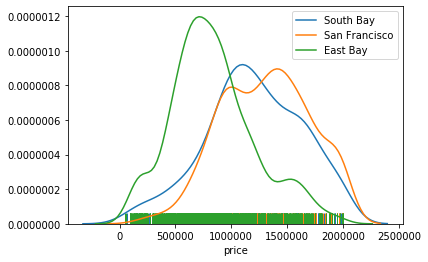

In [32]:
test = data[data['price'] < int(2e6)]
draw_distplot(test, 'area', 'price')

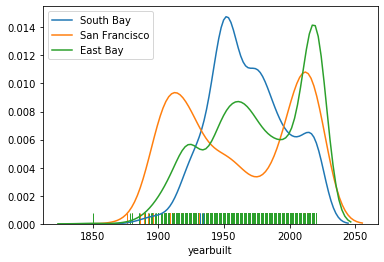

In [33]:
draw_distplot(data, 'area', 'yearbuilt')

It seems that houses in `San Francisco` tend to be older than those in `East Bay` and `South Bay`. There are quite a lot of newer houses in `South Bay` while there is an even mix of old and new houses being sold from `East Bay`.

What about by `type`?

/Users/kenterminator/Desktop/udacity/project/lib/python3.7/site-packages/seaborn/distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/kenterminator/Desktop/udacity/project/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


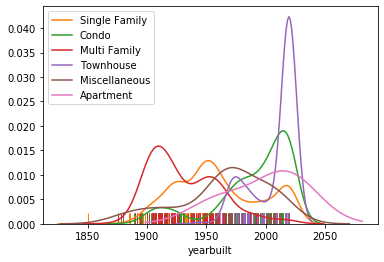

In [34]:
draw_distplot(data, 'type', 'yearbuilt')

This is quite messy. Let's look at the different housing types separately.

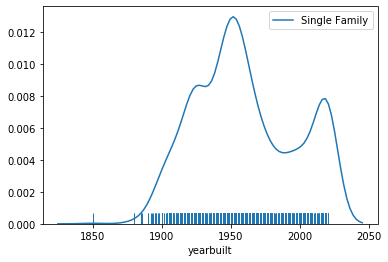

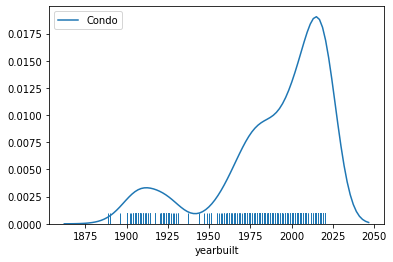

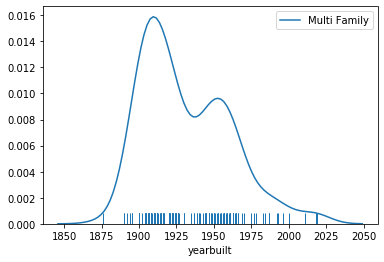

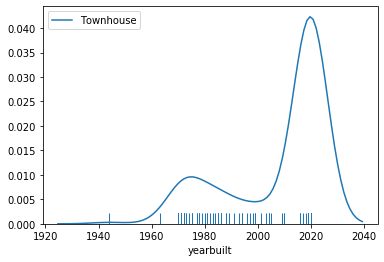

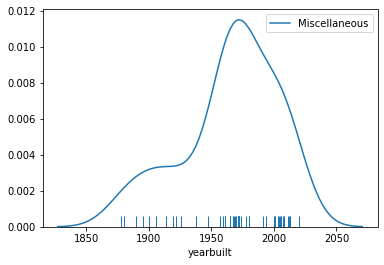

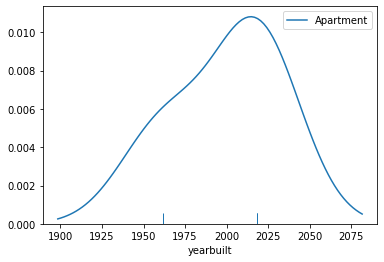

In [35]:
for type_ in np.delete(data['type'].unique(), 0):
    draw_distplot(data, 'type', 'yearbuilt', value=type_, multiple_categories=False)

With this, we find that `Multi Family` houses are older on average, while `Condo` and `Townhouse` are very new. `Single Family` and `Apartment` are more in between.

## Heating and Cooling: "It's getting hot in here..."

I wonder if there's anything interesting going on here...

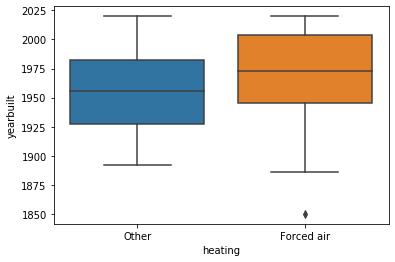

In [36]:
draw_boxplot(data, 'heating', 'yearbuilt');

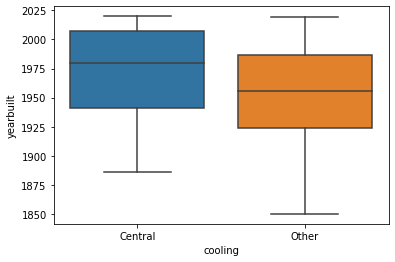

In [37]:
draw_boxplot(data, 'cooling', 'yearbuilt');

Newer houses seem to have `Forced air` heating and `Central` cooling, typical of more modern houses.

In [38]:
summary_statistics(data[data['area'] == 'East Bay'], 'cooling', 'price')

         count          mean       min       50%         max
cooling                                                     
Other     69.0  9.170000e+05   99000.0  707828.0   4288888.0
Central  340.0  1.224644e+06  125000.0  949000.0  10860000.0


In [39]:
summary_statistics(data[data['area'] == 'San Francisco'], 'cooling', 'price')

         count          mean       min        50%         max
cooling                                                      
Other     34.0  3.085170e+06  675000.0  1512500.0  27500000.0
Central  321.0  2.666973e+06  187620.0  1825000.0  32000000.0


In [40]:
summary_statistics(data[data['area'] == 'South Bay'], 'cooling', 'price')

         count          mean       min        50%         max
cooling                                                      
Other     16.0  2.187183e+06  488000.0  1248000.0   9450000.0
Central  159.0  4.839771e+06  275000.0  2749000.0  39988000.0


More than a majority of houses seem to have `Central` cooling and are priced higher for the most part. It'd be interesting to explore why `Central` cooling houses are on average cheaper than `Other` in `San Francisco` in particular, but this may be due to skewness in the data. Let's leave that for now.

## Parking and Spaces: Where to Park My Car

Let's now look at the spread of `parking_spaces` and `parking1` types.

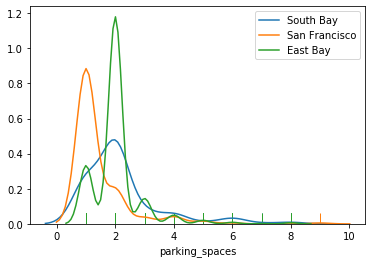

In [41]:
test = data[data['parking_spaces'] < 10]
draw_distplot(test, 'area', 'parking_spaces')

The distribution of `parking_spaces` by `area` here make sense. `San Francisco` houses have mostly 1-2 houses. `East Bay` has mostly 2 houses, while `South Bay` has a middle amount of 1-3 houses but has a larger spread. This makes sense due to the variety of houses in the area.

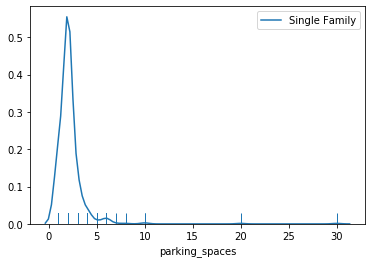

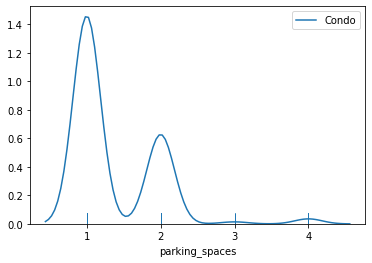

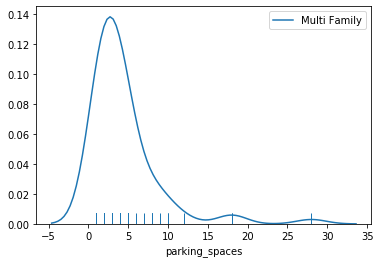

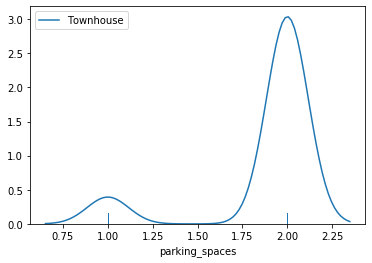

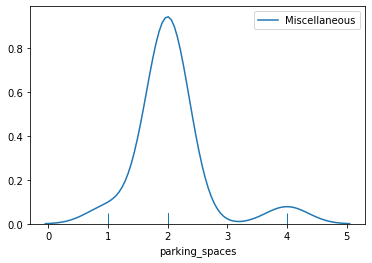

/Users/kenterminator/Desktop/udacity/project/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


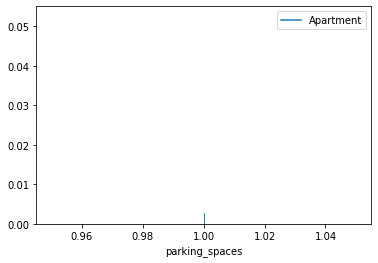

In [42]:
for type_ in np.delete(data['type'].unique(), 0):
    draw_distplot(data, 'type', 'parking_spaces', value=type_, multiple_categories=False)

The distribution of `parking_spaces` by `type` here is interesting. 

`Single Family` and `Multi Family` have the largest spread, with 1-8 and 1-10 respectively. `Condo` has 1-2 parking spaces, while `Townhouse` and `Miscellaneous` have on average 2 parking spaces.

This is in line with what we have been seeing with the size of these houses.

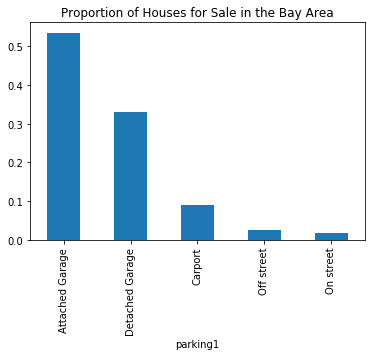

In [43]:
parking_count = count_category(data, 'parking1', title='Proportion of Houses for Sale in the Bay Area', plot=True)

A majority of houses have some type of garage: `Attached Garage` and `Detatched Garage`, while a small amount do not have garages and park `Off street` and `On street`. 

A caveat about this though. `parking_spaces` and `parking1` are currently imputed as mutually exclusive. Hence, there may be large swathes of parking spaces reported which may skew the above proportions away from the `Garage` types.

# Further Considerations

Wow! We've looked of housing numbers in the Bay Area. Let me summarize what I learned given what my objectives are.

## 1. East Bay is a Buying Opportunity

We can see that `San Francisco` and `South Bay` prices are on average around the same boat, and `East Bay` on average has lower prices. There may be historical reasons for this price differential (e.g. Oakland), but from what I'm hearing on the ground, there are districts within `East Bay` that are being developed.

If, as a real estate investor, long term appreciation is your main concern, looking into `East Bay` might be an interesting take.

## 2. Most Houses Sold are `Single Family`

This is good to reaffirm. Most houses that people can sell are `Single Family`. `Multi Family` houses are rare, and it makes sense that on average `Condo`, `Apartment` and `Townhouse` types are fewer on average. This may also mean that most of the investor competition in the `Single Family` type, but further digging on the buyer's market is needed to make that analysis.

## 3. Many Housing Outliers

When it comes to `price` and `sqft`, there are a lot of outliers in the data. Partly, this makes sense due to the exponential nature of housing prices. More than 90% of houses are within the $1-2 million range, while there is a significant portion of houses which are beyond the $4 million mark.

As a beginning investor, I will likely have to focus on the bottom 90-99% of houses (pending `Prediction` analysis). However, it would be interesting to see how many of those outliers I can include into the `Prediction` framework and how many I will have to drop.

## 4. HVAC Opportunity

One small thing that I saw is that older homes tend to be equipped with older `heating` and `cooling` equipment, while a lot of the modern houses have `Forced air` heating and `Central` cooling. While I didn't necessarily see a correlation between `yearbuilt` and `price`, it'd be interesting to compare at a district or even house level the price differential of having older `heating` and `cooling` systems.

One suspicion that I have is that a buyer's market would inflate prices regardless of `yearbuilt` but we will have to see both in the macro `Prediction` analysis and the micro buying phase.

## 5. Seller's Bias

A potential issue with this data set is that since these are all houses that want to be sold, there may be a huge bias towards the types of houses being represented in this dataset.

As I mentioned, many `Apartment`, `Condo` and `Townhouse` types are not being sold in this dataset, but in fact, there may be development and/or buying opportunities in these housing types. Also, more niche buying opportunities are not covered in this dataset at all (e.g. absentee landlord, foreclosure, etc.).

The above analysis is a good starting point for looking at real estate prices, but I would still caution myself for relying too much on it!

# Next Steps

Now that I've dug through the data and understood it more. Let's now model and see what are the biggest contributors to housing prices:

Here are the next steps in the CRISP-DM process:

3. Prepare Data;
4. Data Modeling;
5. Evaluate Results; and
6. Deploy.